![](https://www.nvidia.com/content/dam/en-zz/Solutions/research/research-home-areas-computer-vision-407-ud@2X.jpg)<br>

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
% matplotlib inline

# Getting the data
I will use the simple cats and dogs Kaggle dataset.

## Retrieving the data

In [2]:
FOLDER = "C:/data/images/cats_and_dogs/"

In [3]:
import glob
from PIL import Image

In [4]:
files = glob.glob(FOLDER+"*.JPG")
len(files)

25000

##### Visualizing a sample image

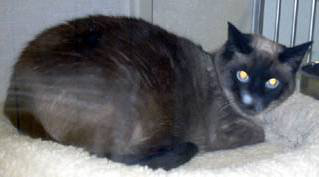

In [5]:
img = Image.open(files[10])
img

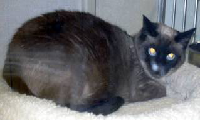

In [6]:
img.resize((200,120))

## Building the dataset
### Building X

In [7]:
X_train = np.vstack([np.expand_dims(np.array(Image.open(file).resize((128,128))),axis = 0) for file in tqdm(files)])

100%|███████████████████████████████████| 25000/25000 [01:13<00:00, 340.96it/s]


In [8]:
X_train.shape

(25000, 128, 128, 3)

### Building the target variable y

In [9]:
y = np.array([int('cat' in os.path.split(file)[1]) for file in files]).reshape(-1,1)
y

array([[1],
       [1],
       [1],
       ..., 
       [0],
       [0],
       [0]])

In [10]:
pd.Series(np.squeeze(y.transpose())).value_counts()

1    12500
0    12500
dtype: int64

## Visualizing the data

In [11]:
def plot_sample(images,n_row=4, n_col=10):
    """
    Helper function to plot a gallery of images
    """
    
    # Random selection
    selection = np.random.randint(0,len(images),n_row*n_col)
    selection = images[selection]
    
    # Plot figure
    plt.figure(figsize=(1.5 * n_col, 1.5 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(selection[i],interpolation="nearest",cmap='Greys')
        plt.xticks(())
        plt.yticks(())

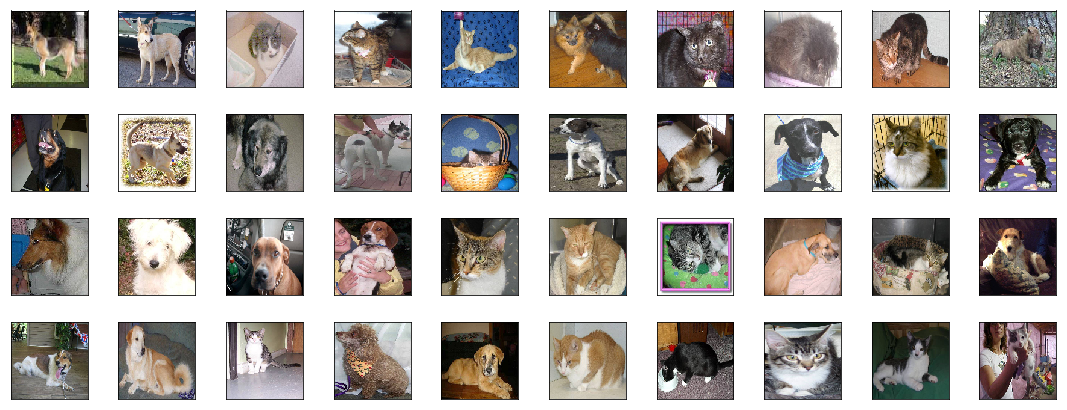

In [12]:
plot_sample(X_train)

## Preparing the data

In [13]:
X_train = np.divide(X_train,255)

# Test with MobileNet

In [14]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback

Using TensorFlow backend.


## Preparing the model

In [15]:
X_train.shape

(25000, 128, 128, 3)

##### Encode the dataset with the MobileNet representation

In [16]:
from keras import applications
model = applications.MobileNet(include_top=False,input_shape=X_train.shape[1:])

In [17]:
%%time
X_transformed = model.predict(X_train,batch_size = 128,verbose=1)

25000/25000 [==============================] - ETA: 72 - ETA: 71 - ETA: 70 - ETA: 70 - ETA: 69 - ETA: 69 - ETA: 69 - ETA: 68 - ETA: 68 - ETA: 68 - ETA: 67 - ETA: 67 - ETA: 66 - ETA: 66 - ETA: 66 - ETA: 65 - ETA: 65 - ETA: 65 - ETA: 64 - ETA: 64 - ETA: 64 - ETA: 63 - ETA: 63 - ETA: 63 - ETA: 62 - ETA: 62 - ETA: 62 - ETA: 61 - ETA: 61 - ETA: 60 - ETA: 60 - ETA: 60 - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 59 - ETA: 58 - ETA: 58 - ETA: 58 - ETA: 57 - ETA: 57 - ETA: 56 - ETA: 56 - ETA: 56 - ETA: 55 - ETA: 55 - ETA: 55 - ETA: 54 - ETA: 54 - ETA: 53 - ETA: 53 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 51 - ETA: 50 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA

In [18]:
X_transformed.shape

(25000, 4, 4, 1024)

##### Concatenate a dense fully connected network to train

In [25]:
top_model = Sequential()
top_model.add(Flatten(input_shape=X_transformed.shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.2))
top_model.add(Dense(1, activation='sigmoid'))

top_model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=['accuracy'])

## Training the model

In [26]:
top_model.fit(X_transformed, y,
          epochs=15,
          batch_size=128,
          validation_split = 0.1,
          verbose=2)
#           callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=False)])

Train on 22500 samples, validate on 2500 samples
Epoch 1/15
24s - loss: 0.2910 - acc: 0.9463 - val_loss: 0.0732 - val_acc: 0.9704
Epoch 2/15
23s - loss: 0.0740 - acc: 0.9737 - val_loss: 0.0579 - val_acc: 0.9796
Epoch 3/15
23s - loss: 0.0754 - acc: 0.9744 - val_loss: 0.0800 - val_acc: 0.9720
Epoch 4/15
23s - loss: 0.0599 - acc: 0.9788 - val_loss: 0.0932 - val_acc: 0.9664
Epoch 5/15
23s - loss: 0.0473 - acc: 0.9842 - val_loss: 0.0581 - val_acc: 0.9784
Epoch 6/15
24s - loss: 0.0398 - acc: 0.9870 - val_loss: 0.0794 - val_acc: 0.9728
Epoch 7/15
23s - loss: 0.0311 - acc: 0.9890 - val_loss: 0.1477 - val_acc: 0.9584
Epoch 8/15
23s - loss: 0.0287 - acc: 0.9891 - val_loss: 0.0764 - val_acc: 0.9768
Epoch 9/15
23s - loss: 0.0256 - acc: 0.9909 - val_loss: 0.0934 - val_acc: 0.9692
Epoch 10/15
23s - loss: 0.0271 - acc: 0.9906 - val_loss: 0.0664 - val_acc: 0.9780
Epoch 11/15
23s - loss: 0.0210 - acc: 0.9919 - val_loss: 0.1088 - val_acc: 0.9668
Epoch 12/15
23s - loss: 0.0210 - acc: 0.9928 - val_loss: 0